In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score ,confusion_matrix, precision_score, recall_score, f1_score, classification_report, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Load the datasets
train_data = pd.read_csv('data/train_data_augmented.csv')
test_data = pd.read_csv('data/test_data_augmented.csv')

In [3]:
# train_data.head(3)

In [4]:
# Add together Plant Production, Imports and Renewables production to get total output to the grid
train_data_prod = train_data['Plant_Production_GWh'] + train_data ['Imports_GWh'] + train_data['Renewables_Production_GWh']
train_data['Grid_Output'] = pd.DataFrame(train_data_prod)
test_data_prod = test_data['Plant_Production_GWh'] + test_data ['Imports_GWh'] + test_data['Renewables_Production_GWh']
test_data['Grid_Output'] = pd.DataFrame(test_data_prod)

train_data.head(3)

,Date,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,powerplants_c02_kt,GDP_mln,Population_k,tmin,tavg,tmax,Grid_Output
0,2003-01-01 00:00:00,0.36,91.04,0.0,0.0,0.0,196.43,398.58,10.9,13.2,15.6,91.04
1,2003-01-16 12:00:00,0.38,91.04,0.0,0.0,0.0,196.43,398.58,9.4,11.8,14.3,91.04
2,2003-02-01 00:00:00,0.40,93.55,0.0,0.0,0.0,201.85,398.58,7.9,10.4,13.0,93.55


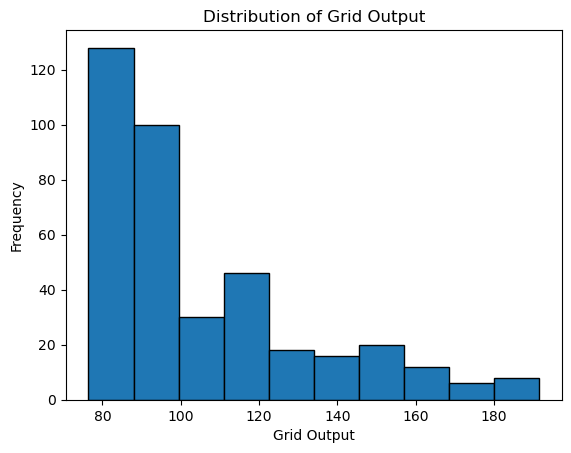

In [5]:
counts, bin_edges, _ = plt.hist(train_data['Grid_Output'], bins=10, edgecolor='black')

plt.xlabel('Grid Output')
plt.ylabel('Frequency')
plt.title('Distribution of Grid Output')

plt.show()

In [6]:
bin_edges

array([ 76.44 ,  87.951,  99.462, 110.973, 122.484, 133.995, 145.506,
       157.017, 168.528, 180.039, 191.55 ])

In [7]:
# Manually define the bin edges since the lower frequency ones can be grouped

bin_edges = [-np.inf, 120, 160, np.inf]

In [8]:
# Create labels for the bins
labels = [i for i in range(len(bin_edges) - 1)]

# Use pd.cut to categorize the data into bins
train_data['Grid_Category'] = pd.cut(train_data['Grid_Output'], bins=bin_edges, labels=labels, include_lowest=True)
test_data['Grid_Category'] = pd.cut(test_data['Grid_Output'], bins=bin_edges, labels=labels, include_lowest=True)

In [9]:
bin_ranges = pd.DataFrame({'Bin': labels,'Bin Edge Lower': bin_edges[:-1],'Bin Edge Upper': bin_edges[1:],})
bin_ranges

,Bin,Bin Edge Lower,Bin Edge Upper
0,0,-inf,120.0
1,1,120.0,160.0
2,2,160.0,inf


In [10]:
# Display the DataFrame with the new categorical column
train_data.head(3)

,Date,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,powerplants_c02_kt,GDP_mln,Population_k,tmin,tavg,tmax,Grid_Output,Grid_Category
0,2003-01-01 00:00:00,0.36,91.04,0.0,0.0,0.0,196.43,398.58,10.9,13.2,15.6,91.04,0
1,2003-01-16 12:00:00,0.38,91.04,0.0,0.0,0.0,196.43,398.58,9.4,11.8,14.3,91.04,0
2,2003-02-01 00:00:00,0.40,93.55,0.0,0.0,0.0,201.85,398.58,7.9,10.4,13.0,93.55,0


In [11]:
test_data.head(3)
#test_data

,Date,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,powerplants_c02_kt,GDP_mln,Population_k,tmin,tavg,tmax,Grid_Output,Grid_Category
0,2019-01-01 00:00:00,0.440,112.38,23.480,5.225,31.53,604.45,502.440833,8.80,11.6,14.40,141.085,1
1,2019-01-16 12:00:00,0.435,112.38,23.480,5.225,31.53,604.45,503.250417,8.75,11.8,14.85,141.085,1
2,2019-02-01 00:00:00,0.430,99.77,30.295,5.965,27.99,536.63,504.060000,8.70,12.0,15.30,136.030,1


The parameters of the KNN Algorithm were tweaked as follows, with information being taken from the scikit learn documentation accessed 03/12/2023:
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

## Weights Parameter

The 'weights' parameter can either be set to *uniform* or *distance* whereby the former weights all points in each neighbourhood equally, while the latter weights points by the inverse of their distance such that close neighbours of a query point will have a greater influence than neighbours which are further away.

## Algorithm Parameter

Can either be 'auto', 'ball_tree', 'kd_tree' or 'brute'
*ChatGPT Prompt: What is the difference between Ball Tree and KD Tree? Use simple terms, if possible an analogy.*
In the context of nearest neighbors algorithms, both Ball Tree and KD Tree are data structures designed to efficiently organize and search for points in a multidimensional space. Here's a simple analogy to help illustrate the difference between Ball Tree and KD Tree:

Analogy:
- KD Tree (K-Dimensional Tree):
Imagine you have a stack of papers with points plotted on a graph. Each paper represents a different dimension in your dataset (e.g., one paper for x, another for y, etc.). A KD Tree is like organizing these papers in a way that you split the points along one dimension at a time, creating a binary tree structure. At each level of the tree, you choose a different dimension to split on, alternating between x, y, z, and so on. This way, you efficiently narrow down the search for nearest neighbors by navigating through different dimensions in a structured manner.

- Ball Tree:
Now, envision your points as dots in space, and imagine drawing spheres around groups of points. A Ball Tree is like organizing your points based on these spheres. Instead of focusing on one dimension at a time, you create a hierarchy of spheres that encapsulate clusters of points. When searching for nearest neighbors, you can quickly eliminate entire clusters of points if they are farther away than the distance you care about. It's a bit like saying, "Okay, this entire bunch of points is definitely too far away, so I don't need to check each one individually."

Key Differences:
- KD Tree: Divides the space along one dimension at a time, creating a binary tree structure.
- Ball Tree: Groups points into clusters based on spheres, allowing for a more flexible and efficient structure when dealing with non-uniformly distributed data.

In summary, while both KD Tree and Ball Tree aim to speed up nearest neighbors searches in high-dimensional spaces, they differ in their approach to organizing and navigating through that space. KD Tree splits along dimensions, whereas Ball Tree groups points into clusters based on spheres. The choice between them often depends on the characteristics of your data and the specific requirements of your nearest neighbors search.

---

Tuning this paramater to any one of 'auto', 'ball_tree', 'kd_tree' or 'brute' had no effect on the model. However, in the context of the model being applied to a more vast and large data set, ball_tree was selected since it appears most suitable. The features are not very high dimensional, thus the Ball Tree algorithm seems more suitable.

## Leaf Size

Known to affect the speed of construction and query and the memory required to store the tree. The documentation states that "the optimal value depends on the nature of the problem".

*ChatGPT Prompt: How would one decide the optimal leaf size for a KNN Algorithm? Is this just trial and error? Keep it short, please.*
Choosing the optimal leaf size for a KNN algorithm often involves experimentation. You can try different values and assess the algorithm's performance using cross-validation or a validation set. Smaller leaf sizes may capture more local details but may lead to overfitting, while larger leaf sizes can smooth out the decision boundaries but may oversimplify. It's a trade-off, and you can use performance metrics to guide your choice.

---

Tuning this parameter had once again no effect on the model. Therefore it was left to the 'auto' value of 30.

---

Since tuning the parameters had, so far, no effect on the metrics, I asked ChatGPT the following:

*ChatGPT Prompt: Tweaking the paramaters of the KNN Model such as the weights, algorithm and leaf size is having absolutely no effect on the metrics. Why could this be?*

If tweaking parameters such as weights, algorithm, and leaf size is not having any noticeable effect on the metrics of your KNN model, there are several possible reasons for this:

1. Data Characteristics: The choice of parameters might not have a significant impact on your specific dataset. Some datasets may not be sensitive to changes in certain KNN parameters.
2. Overfitting or Underfitting: The model may already be underfitting or overfitting, and adjusting these parameters does not address the underlying issue. Consider checking for signs of underfitting or overfitting, such as a consistently low or high accuracy, respectively.
3. Irrelevant Features: If your dataset contains irrelevant or noisy features, adjusting KNN parameters might not lead to substantial improvements. Consider feature selection or engineering to improve the relevance of features.
4. Scale of Features: Ensure that the features are on a similar scale. KNN is sensitive to the scale of features, and if features are on vastly different scales, certain features may dominate the distance calculations.
5. Insufficient Data: If your dataset is small, parameter adjustments might not have a significant impact. KNN tends to perform better with larger datasets.
6. Data Quality: Check for outliers or errors in the data. Outliers can heavily influence the nearest neighbor calculations and may affect the model's sensitivity to parameter changes.
7. Evaluation Metrics: Consider using different evaluation metrics or additional metrics to assess model performance. Some metrics may be more sensitive to changes than others.
8. Hyperparameter Range: Ensure that you are exploring a sufficiently broad range of hyperparameter values in your search. It's possible that the optimal values are outside the range you've considered.
9. Randomness: Some algorithms, especially when used with randomization, may exhibit variability in results. Ensure that you are running multiple experiments and assessing the average behavior.
10. Implementation Issues: Double-check your code to ensure that the parameter changes are being applied correctly. It's possible that there is an error in how the parameters are set or that the model is not being retrained.

If you are still facing challenges, it might be helpful to provide more details about your dataset, the specific parameters you are adjusting, and the metrics you are using for evaluation. Additionally, considering more advanced techniques like feature engineering, ensemble methods, or alternative algorithms might be explored depending on the characteristics of your problem.

---

Given the above, I decided to continue testing since I was sure that the scale of features was correct, outliers had been tackled and I am aware that the data set is not very large.

## p parameter

The p parameter is the power parameter fir the Minkwoski metrics.

- p=1: Manhattan Distance
- p=2: Euclidean distance

The default p=2 resulted in better metrics than p=1.

In [12]:
# Prepare the data
X_train = train_data[['tmax', 'Population_k']]
y_train = train_data['Grid_Category']
X_test = test_data[['tmax', 'Population_k']]
y_test = test_data['Grid_Category'] 

# Normalize features
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
# Normalize the test set on the same scale the train set was normalized upon
X_test_normalized = scaler.transform(X_test)

# Train the KNN model
k_neighbors = 3  # You can adjust this value based on your preference
knn_model = KNeighborsClassifier(n_neighbors=k_neighbors, weights='uniform', algorithm='ball_tree')
knn_model.fit(X_train_normalized, y_train)

# Make predictions on the testing set
y_pred = knn_model.predict(X_test_normalized)

In [13]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

# Precision, Recall, and F1 Score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Classification Report
class_report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{class_report}')

Accuracy: 0.6458333333333334
Confusion Matrix:
[[ 6 11  1]
 [12 38  4]
 [ 0  6 18]]
Precision: 0.6467885375494071
Recall: 0.6458333333333334
F1 Score: 0.646191196564513
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.33      0.33        18
           1       0.69      0.70      0.70        54
           2       0.78      0.75      0.77        24

    accuracy                           0.65        96
   macro avg       0.60      0.60      0.60        96
weighted avg       0.65      0.65      0.65        96



In [14]:
# Add the predicted category to the test_data DataFrame
test_data['Predicted_Category'] = y_pred

In [15]:
test_data.head(3)

,Date,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,powerplants_c02_kt,GDP_mln,Population_k,tmin,tavg,tmax,Grid_Output,Grid_Category,Predicted_Category
0,2019-01-01 00:00:00,0.440,112.38,23.480,5.225,31.53,604.45,502.440833,8.80,11.6,14.40,141.085,1,1
1,2019-01-16 12:00:00,0.435,112.38,23.480,5.225,31.53,604.45,503.250417,8.75,11.8,14.85,141.085,1,1
2,2019-02-01 00:00:00,0.430,99.77,30.295,5.965,27.99,536.63,504.060000,8.70,12.0,15.30,136.030,1,1


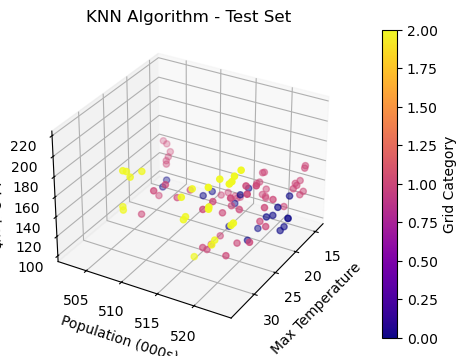

In [53]:
# Visualize the test set
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter('tmax', 'Population_k', 'Grid_Output', c='Predicted_Category', data=test_data, cmap='plasma')

ax.set_title('KNN Algorithm - Test Set')
ax.set_xlabel('Max Temperature')
ax.set_ylabel('Population (000s)')
ax.set_zlabel('Grid Output')

ax.view_init(elev=30,azim=30)

# Add colorbar
cb = plt.colorbar(scatter)
cb.set_label('Grid Category')

plt.show()

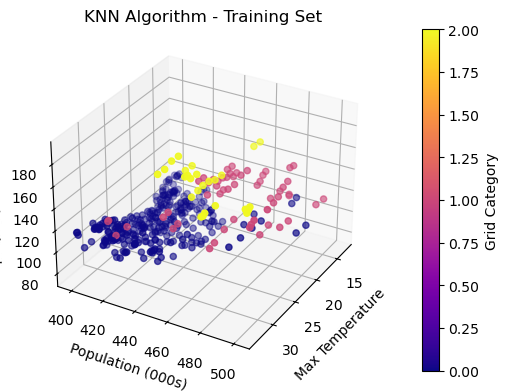

In [59]:
# Visualize the training set
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter('tmax', 'Population_k', 'Grid_Output', c='Grid_Category', data=train_data, cmap='plasma')

ax.set_title('KNN Algorithm - Training Set')
ax.set_xlabel('Max Temperature')
ax.set_ylabel('Population (000s)')
ax.set_zlabel('Grid Output')

ax.view_init(elev=30,azim=30)

# Add colorbar
cb = plt.colorbar(scatter)
cb.set_label('Grid Category')

plt.tight_layout()
plt.show()

# Scatter plot for visualization
sns.scatterplot(x='tmax', y='Grid_Output', hue='Predicted_Category', data=test_data, palette='plasma')
plt.title('KNN Predicted Clusters in Test Set')
plt.xlabel('tmax')
plt.ylabel('Grid_Output')
plt.show()